In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from tqdm.auto import tqdm




#загрузка данных
airports = pd.read_csv('airports.csv')
flights = pd.read_csv('flights.csv')
airlines = pd.read_csv('airlines.csv')

#добавляю колонку с датой, выбираю период(данные за октябрь теряются, другой формат наименования аэропортов)

flights['HOUR'] = flights['SCHEDULED_DEPARTURE']//100
flights['MINUTE'] = flights['SCHEDULED_DEPARTURE']%100
flights['DATE_DAY'] = pd.to_datetime(flights[['YEAR', 'MONTH', 'DAY']])
flights['DATE_TIME'] = pd.to_datetime(flights[['YEAR', 'MONTH', 'DAY', 'HOUR', 'MINUTE']])
flights['DATE_HOUR'] = pd.to_datetime(flights[['YEAR', 'MONTH', 'DAY', 'HOUR']])

flights['PROBABILITY'] = np.where(flights['DEPARTURE_DELAY']>0, 0, 1)
flights['ONLY_DEPARTURE'] = flights['DEPARTURE_DELAY'] - flights['ARRIVAL_DELAY']



flights = flights.loc[flights['DATE_DAY'].between('2015-01-01', '2015-09-30')]

B = flights.groupby(['ORIGIN_AIRPORT', 'DATE_HOUR'])['DATE_DAY'].count().reset_index().rename(columns={'DATE_DAY': 'COUNT_HOUR'})
flights = flights.merge(B, how='left', left_on=['ORIGIN_AIRPORT', 'DATE_HOUR'], right_on = ['ORIGIN_AIRPORT', 'DATE_HOUR'])
B = flights.groupby(['ORIGIN_AIRPORT', 'DATE_DAY'])['DATE_HOUR'].count().reset_index().rename(columns={'DATE_HOUR': 'COUNT_DAY'})
flights = flights.merge(B, how='left', left_on=['ORIGIN_AIRPORT', 'DATE_DAY'], right_on = ['ORIGIN_AIRPORT', 'DATE_DAY'])




/var/folders/m9/x7jxk9jx2g9ch4ngnwz3n8wh0000gn/T/ipykernel_59474/540131829.py:18: DtypeWarning: Columns (7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  flights = pd.read_csv('flights.csv')


In [ ]:
A = pd.DataFrame(flights.isna().sum())
A.plot(kind='bar', subplots=True, figsize=[16, 9], legend=None)


In [ ]:
A.rename(columns={0:'HBHB'})

In [ ]:
colormap = plt.cm.viridis
plt.figure(figsize=(30,30))
plt.title('Попарная корреляция', y=1.05, size=20)
sns.heatmap(flights.corr(), square=True, annot=True, cmap=colormap)
plt.show()

In [ ]:
flights.columns

In [79]:
C = flights[['MONTH', 'DAY_OF_WEEK', 'AIRLINE','SCHEDULED_TIME',
       'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT',
       'SCHEDULED_DEPARTURE', 'DISTANCE',
       'ARRIVAL_DELAY', 'HOUR', 'MINUTE',
       'DATE_HOUR', 'PROBABILITY', 'COUNT_HOUR', 'COUNT_DAY']]

In [80]:
C = C.query("ORIGIN_AIRPORT == 'HNL'")

In [ ]:
A = pd.DataFrame(C.isna().sum())
A.plot(kind='bar', subplots=True, figsize=[16, 9], legend='1', title='gvcsvdg')


In [81]:
C.dropna(inplace=True)

In [82]:
a_list = []
le = LabelEncoder()
for column in C.columns:
    if C.dtypes['{}'.format(column)] == 'object':
        a_list.append(column)
        #le = LabelEncoder()
        C['{}'.format(column)] = le.fit_transform(C['{}'.format(column)])
        


In [46]:
C.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 0 entries
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   MONTH                0 non-null      int64  
 1   DAY_OF_WEEK          0 non-null      int64  
 2   AIRLINE              0 non-null      int64  
 3   SCHEDULED_TIME       0 non-null      float64
 4   ORIGIN_AIRPORT       0 non-null      int64  
 5   DESTINATION_AIRPORT  0 non-null      int64  
 6   SCHEDULED_DEPARTURE  0 non-null      int64  
 7   DISTANCE             0 non-null      int64  
 8   HOUR                 0 non-null      int64  
 9   MINUTE               0 non-null      int64  
 10  PROBABILITY          0 non-null      int64  
 11  COUNT_HOUR           0 non-null      int64  
 12  COUNT_DAY            0 non-null      int64  
dtypes: float64(1), int64(12)
memory usage: 0.0 bytes


In [ ]:
colormap = plt.cm.viridis
plt.figure(figsize=(30,20))
plt.title('Попарная корреляция', y=1.05, size=20)
sns.heatmap(C.corr(), square=True, annot=True, cmap=colormap)
plt.show()

In [83]:
C.set_index('DATE_HOUR', inplace=True)

In [84]:
#удаляю выбросы - 1,5 межквантильных размаха из колонки с задержкой прилета
Q1 = C['ARRIVAL_DELAY'].quantile(0.25)
Q3 = C['ARRIVAL_DELAY'].quantile(0.75)
IQR = Q3 - Q1
a = C[(C['ARRIVAL_DELAY'] < Q1-1.5*IQR ) | (C['ARRIVAL_DELAY'] > Q3+1.5*IQR)]['ARRIVAL_DELAY'].reset_index()
    
#список с исключениями
a = list(a.ARRIVAL_DELAY)
#исключаю выбросы
C = C.query("ARRIVAL_DELAY != @a")

In [85]:
C.drop(['PROBABILITY'], axis=1, inplace=True)

In [86]:
#формирую выборки - обучающую и тестовую
X_train,X_test, y_train, y_test = train_test_split(C.drop('ARRIVAL_DELAY',axis=1),
                                                        C.ARRIVAL_DELAY,
                                                        shuffle = False,# временной ряд, отключаем перемешивание
                                                        test_size = 0.25)

In [89]:
dtc = DecisionTreeClassifier(max_depth=10)
#sc = StandardScaler()
dtc.fit(X_train, y_train)
print('Ошибка на обучающей выборке', (mean_squared_error(y_train, dtc.predict(X_train)))**0.5)
pred = dtc.predict(X_test)
print('Ошибка на тесте', (mean_squared_error(y_test, pred))**0.5)

Ошибка на обучающей выборке 10.044713880054443
Ошибка на тесте 11.460360747129144


In [87]:
max_depth_range = list(range(1, 20))# List to store the average RMSE for each value of max_depth:
accuracy = []
for depth in max_depth_range:
    
    clf = DecisionTreeClassifier(max_depth = depth, 
                             random_state = False)
    clf.fit(X_train, y_train)    
    score = clf.score(X_test, y_test)
    accuracy.append(score)

In [94]:
accuracy

[0.05299772324816595,
 0.05514798886921326,
 0.05540096129521882,
 0.05198583354414369,
 0.04932962307108525,
 0.05223880597014925,
 0.05110043005312421,
 0.05400961295218821,
 0.052365292183152036,
 0.05135340247912978,
 0.05008854034910195,
 0.05198583354414369,
 0.04642044017202125,
 0.04869719200607134,
 0.04376422969896281,
 0.04452314697697951,
 0.04667341259802681,
 0.044649633189982295,
 0.045155578041993424]

In [90]:
O = pd.DataFrame(accuracy)

<AxesSubplot:>

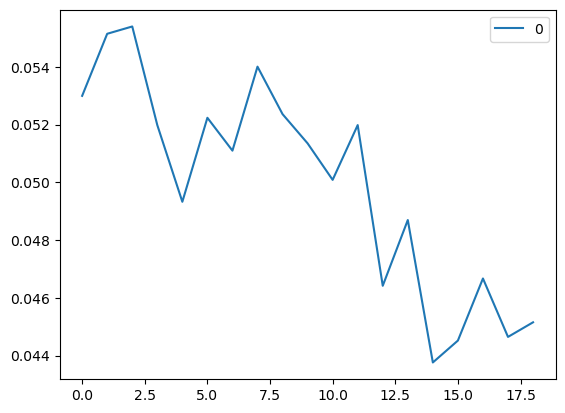

In [95]:
O.plot()

In [ ]:
from sklearn import tree
text_representation = tree.export_text(dtc)
print(text_representation)

In [ ]:
y_test = y_test.reset_index()
y_test['PRED'] = list(pred)
y_test = y_test.set_index('DATE_HOUR')
X_test['ARRIVAL_DELAY'] = y_test['ARRIVAL_DELAY']
X_test['PRED'] = y_test['PRED']


In [ ]:
X_test['ARRIVAL_DELAY'].mean()

In [ ]:
X_test['PRED'].mean()

In [ ]:
for column in a_list:
        X_test['{}'.format(column)] = le.inverse_transform(X_test['{}'.format(column)])
X_test['PROBABILITY'] = np.where(X_test['ARRIVAL_DELAY']>0, 0, 1)
X_test['PROBABILITY_PRED'] = np.where(X_test['PRED']>0, 0, 1)


In [ ]:
X_test1 = X_test.reset_index()#.loc[X_test.reset_index()['DATE_HOUR'].between('2015-09-30 00:00:00', '2015-09-30 23:00:00')]


In [ ]:
start_airport = np.random.choice(flights['ORIGIN_AIRPORT'].unique()) 
X_test1['MSE'] = (X_test1['PRED'] - X_test1['ARRIVAL_DELAY'])**2


In [ ]:
X_test1 = X_test1.query("ORIGIN_AIRPORT == '{}'".format(start_airport))

In [ ]:
X_test1.groupby('DESTINATION_AIRPORT').mean().sort_values('MSE', ascending=True)

In [ ]:
A = flights.groupby('DATE_DAY')['HOUR'].count().reset_index().rename(columns={'HOUR':'Количество_вылетов'})
A['Количество_вылетов'] = A['Количество_вылетов']/A['Количество_вылетов'].max()

In [ ]:
B = flights.groupby('DATE_DAY')['PROBABILITY'].mean().reset_index().rename(columns={'PROBABILITY':'Средняя_вероятность'})

In [ ]:
A = A.merge(B, how='left', left_on='DATE_DAY', right_on='DATE_DAY')

In [ ]:
A.set_index('DATE_DAY').plot(figsize=[16,9])

In [ ]:
fig = px.box(flights['ARRIVAL_DELAY'])
fig.show()

In [ ]:
fig = px.box(C['ARRIVAL_DELAY'])
fig.show()

In [ ]:
C

In [ ]:

print (C['ARRIVAL_DELAY']. cov (C['AIRLINE']))


In [ ]:
colormap = plt.cm.viridis
plt.figure(figsize=(30,20))
plt.title('Попарная корреляция', y=1.05, size=20)
sns.heatmap(skalre_df.cov(), square=True, annot=True, cmap=colormap)
plt.show()


In [ ]:
from sklearn.preprocessing import MinMaxScaler


In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
rescaledX = scaler.fit_transform(C)
col = C.columns
skalre_df = pd.DataFrame(rescaledX, columns=col )




In [ ]:
skalre_df

In [ ]:
#функция для генерации колонок
def make_features(data, max_lag, rolling_mean_size):
    data['year'] = data.DATE_DAY.dt.year
    data['month'] = data.DATE_DAY.dt.month
    data['day'] = data.DATE_DAY.dt.day
    data['dayofweek'] = data.DATE_DAY.dt.dayofweek
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['ARRIVAL_DELAY'].shift(lag)
    data['y_mean'] = data['ARRIVAL_DELAY'].shift().rolling(rolling_mean_size).mean().copy()

#функция для рассчета вероятности
def get_probability(y_test):
    y_test = y_test.reset_index()
    y_test['probability'] = np.where(y_test['ARRIVAL_DELAY']>0, 0, 1)
    return round(y_test['probability'].mean()*100, 2)

In [ ]:

#выбор случайного наименования аэропорта

#формируем фрейм со случайно выбранным аэропортом вылета
df = flights.query("ORIGIN_AIRPORT == '{}'".format(start_airport))

#будующий фрейм данных, содержит наименование аэропорта прилета, метрику, вероятность, число перелетов в тестовом аборе данных
total = pd.DataFrame(columns=['name', 'RMSE', 'ARRIVAL_DELAY'])

#перебор аэропортов прилета
for d_airport in df['DESTINATION_AIRPORT'].unique():
    d_df = df.query("DESTINATION_AIRPORT == '{}'".format(d_airport))
    
    
    #удаляю выбросы - 1,5 межквантильных размаха из колонки с задержкой прилета
    Q1 = d_df['ARRIVAL_DELAY'].quantile(0.25)
    Q3 = d_df['ARRIVAL_DELAY'].quantile(0.75)
    IQR = Q3 - Q1
    a = d_df[(d_df['ARRIVAL_DELAY'] < Q1-1.5*IQR ) | (d_df['ARRIVAL_DELAY'] > Q3+1.5*IQR)]['ARRIVAL_DELAY'].reset_index()
    
    #список с исключениями
    a = list(a.ARRIVAL_DELAY)
    #исключаю выбросы
    d_df = d_df.query("ARRIVAL_DELAY != @a")
    d = d_df.DATE_DAY.max()
    d_df.loc[(d_df.DATE_DAY == d),'ARRIVAL_DELAY']=0


    try:   

        #генерируем показатели
        d_df = d_df.groupby('DATE_DAY')['ARRIVAL_DELAY'].mean().reset_index()
        make_features(d_df,21,7)
        d_df.dropna(inplace=True)
        d_df.set_index('DATE_DAY', inplace=True)



        #формирую выборки - обучающую и тестовую
        X_train,X_test, y_train, y_test = train_test_split(d_df.drop('ARRIVAL_DELAY',axis=1),
                                                        d_df.ARRIVAL_DELAY,
                                                        shuffle = False,# временной ряд, отключаем перемешивание
                                                        test_size = 0.25)

        #обучаю и делаю предсказание
        lr = LinearRegression()
        lr.fit(X_train, y_train)
        pred = lr.predict(X_test)

        #формирую словарь, далее будем накапливать данные в df total
        t = {'name':'{}'.format(d_airport), 'RMSE':round(np.sqrt(mean_squared_error(y_test, pred)), 2), 
        'ARRIVAL_DELAY':round(pred[-1], 2)}
        total = total.append(t, ignore_index=True)

    except Exception as e:
        continue



#добавляю и аэропорт вылета(нужен для дальнейшего постоения графика, данные в словаре формируют большой желтый point на карте - аэропорт вылета)
t = {'name':'{}'.format(start_airport), 'RMSE':total.RMSE.mean()*2, 'ARRIVAL_DELAY':0}
#сортируем данные по метрике и вероятности положительного исхода прилета
total = total.sort_values(by=['RMSE','ARRIVAL_DELAY'],ascending=[True, True])
total = total.head(3)
total = total.append(t, ignore_index=True)


map_air = airports.merge(total, how='right', left_on='IATA_CODE', right_on='name')

print(total.set_index('name')[:-1])


fig = px.scatter_mapbox(total,
                        lon = map_air.LONGITUDE,
                        lat = map_air.LATITUDE,
                        zoom = 3,
                        color = map_air.RMSE,
                        size = map_air.RMSE,
                        width = 800,
                        height = 600,
)
fig.update_layout(mapbox_style='open-street-map')
fig.show()


In [ ]:
flights.groupby('AIRLINE')['DATE_HOUR'].count().plot(kind='bar')

In [ ]:
#plt.axis('off')

A = flights.groupby('ORIGIN_AIRPORT')['DATE_HOUR'].count()
A.plot(kind='bar', title='gvcsvdg', figsize=[16, 9], legend=True, xlabel='bdsvu')


In [ ]:
A = A.reset_index()

In [ ]:
A.ORIGIN_AIRPORT.nunique()

In [ ]:
plt.hist(x=A.DATE_HOUR)

In [ ]:
a = flights.groupby('ORIGIN_AIRPORT')['DATE_HOUR'].count().sort_values(ascending=False).reset_index()
b = airports.merge(a, how='right', left_on='IATA_CODE', right_on='ORIGIN_AIRPORT')

In [ ]:
fig = px.scatter_mapbox(b,
                        lon = b.LONGITUDE,
                        lat = b.LATITUDE,
                        zoom = 3,
                        color = b.DATE_HOUR,
                        size = b.DATE_HOUR,
                        hover_name="IATA_CODE",
                        width = 800,
                        height = 600,
)
fig.update_layout(mapbox_style='open-street-map')
fig.show()

In [ ]:
airports.IATA_CODE.unique()

In [ ]:
flights

In [ ]:
airports.query("IATA_CODE == 'ATL'")

In [ ]:
ATL = flights.query("ORIGIN_AIRPORT == 'ATL'")

In [ ]:
weather = pd.read_csv('Atlanta.csv')

In [ ]:
weather = weather[['precipMM', 'tempC', 'visibility', 'windspeedKmph', 'date_time']]
weather['date_time'] = pd.to_datetime(weather['date_time'])

In [ ]:
ATL = ATL.merge(weather, how='left', left_on='DATE_HOUR', right_on='date_time')

In [ ]:
ATL.drop('date_time', inplace=True, axis=1)

In [ ]:
ATL.dropna(inplace=True)

In [ ]:
ATL.isna().sum()

In [ ]:
ATL

In [ ]:
colormap = plt.cm.viridis
plt.figure(figsize=(30,30))
plt.title('Попарная корреляция', y=1.05, size=20)
sns.heatmap(ATL.corr(), square=True, annot=True, cmap=colormap)
plt.show()

In [97]:
airports.IATA_CODE.unique()

array(['ABE', 'ABI', 'ABQ', 'ABR', 'ABY', 'ACK', 'ACT', 'ACV', 'ACY',
       'ADK', 'ADQ', 'AEX', 'AGS', 'AKN', 'ALB', 'ALO', 'AMA', 'ANC',
       'APN', 'ASE', 'ATL', 'ATW', 'AUS', 'AVL', 'AVP', 'AZO', 'BDL',
       'BET', 'BFL', 'BGM', 'BGR', 'BHM', 'BIL', 'BIS', 'BJI', 'BLI',
       'BMI', 'BNA', 'BOI', 'BOS', 'BPT', 'BQK', 'BQN', 'BRD', 'BRO',
       'BRW', 'BTM', 'BTR', 'BTV', 'BUF', 'BUR', 'BWI', 'BZN', 'CAE',
       'CAK', 'CDC', 'CDV', 'CEC', 'CHA', 'CHO', 'CHS', 'CID', 'CIU',
       'CLD', 'CLE', 'CLL', 'CLT', 'CMH', 'CMI', 'CMX', 'CNY', 'COD',
       'COS', 'COU', 'CPR', 'CRP', 'CRW', 'CSG', 'CVG', 'CWA', 'DAB',
       'DAL', 'DAY', 'DBQ', 'DCA', 'DEN', 'DFW', 'DHN', 'DIK', 'DLG',
       'DLH', 'DRO', 'DSM', 'DTW', 'DVL', 'EAU', 'ECP', 'EGE', 'EKO',
       'ELM', 'ELP', 'ERI', 'ESC', 'EUG', 'EVV', 'EWN', 'EWR', 'EYW',
       'FAI', 'FAR', 'FAT', 'FAY', 'FCA', 'FLG', 'FLL', 'FNT', 'FSD',
       'FSM', 'FWA', 'GCC', 'GCK', 'GEG', 'GFK', 'GGG', 'GJT', 'GNV',
       'GPT', 'GRB',